## Vorlesung 6: Schätzen & Konfidenzintervalle

*Mittelwert schätzen, Unsicherheit messen, Konfidenzintervalle berechnen, Bootstrap einsetzen.*


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
plt.style.use("seaborn-v0_8-whitegrid")

csv_path = "OECD.WISE.WDP,DSD_HSL@DF_HSL_CWB,+all.csv"
df = pd.read_csv(csv_path, low_memory=False)

unnamed_cols = [c for c in df.columns if "unnamed" in c.lower()]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)

df = df.rename(
    columns={
        "REF_AREA": "country",
        "MEASURE": "measure",
        "UNIT_MEASURE": "unit",
        "TIME_PERIOD": "year",
        "OBS_VALUE": "value",
    }
)

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")
for cat_col in ("country", "measure", "unit"):
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].astype("category")

# --- Lecture 6 focus: Auswahl eines Indikators & vorbereiteter Datensatz ----------------------
measure_selected = df["measure"].value_counts().index[0]  # bei Bedarf anpassen
year_min, year_max = None, None  # Zeitfenster setzen, z.B. 2005, 2020

m = df[df["measure"] == measure_selected].copy()
if year_min is not None:
    m = m[m["year"] >= year_min]
if year_max is not None:
    m = m[m["year"] <= year_max]

m = m[pd.to_numeric(m["value"], errors="coerce").notna()]
m["value"] = m["value"].astype(float)

rng = np.random.default_rng(42)  # für Bootstrap/Simulation in VL6


In [16]:
# Übersicht der verfügbaren Indikatoren (erste 20)
df["measure"].value_counts().head(20)


measure
2_1         8065
11_3        7557
10_2_DEP    7549
7_1         7549
10_2        7549
7_1_DEP     7543
5_2         5922
11_2        5684
2_3         5461
2_7         5149
2_5         2812
5_1         2700
5_3         2457
10_1        2309
2_4         2161
5_2_DEP     1977
11_1        1969
11_1_DEP    1288
2_2         1140
9_3          940
Name: count, dtype: int64

In [17]:
# Auswahl eines Indikators, hier automatisch der häufigste
measure_selected = df["measure"].value_counts().index[0]

# Optionaler Zeitraum (None = nicht filtern)
year_min, year_max = None, None

# Filter auf den gewünschten Indikator
m = df[df["measure"] == measure_selected].copy()

# Zeitraum einengen, falls Werte gesetzt wurden
if year_min is not None:
    m = m[m["year"] >= year_min]
if year_max is not None:
    m = m[m["year"] <= year_max]

# Nur numerische Werte behalten
m = m[pd.to_numeric(m["value"], errors="coerce").notna()]
m["value"] = m["value"].astype(float)

m.head()


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,country,Reference area,measure,Measure,unit,Unit of measure,...,value,Observation value,OBS_STATUS,Observation status,UNIT_MULT,Unit multiplier,DECIMALS,Decimals,BASE_PER,Base period
37840,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB(1.1),Current well-being,I,AUS,Australia,2_1,Employment rate,PT_POP_Y25T64_SUB,Percentage of population aged 25-64 years in t...,...,77.342133,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
37841,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB(1.1),Current well-being,I,AUS,Australia,2_1,Employment rate,PT_POP_Y25T64_SUB,Percentage of population aged 25-64 years in t...,...,77.966560,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
37842,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB(1.1),Current well-being,I,AUS,Australia,2_1,Employment rate,PT_POP_Y25T64_SUB,Percentage of population aged 25-64 years in t...,...,78.176628,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
37843,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB(1.1),Current well-being,I,AUS,Australia,2_1,Employment rate,PT_POP_Y25T64_SUB,Percentage of population aged 25-64 years in t...,...,78.158249,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
37844,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB(1.1),Current well-being,I,AUS,Australia,2_1,Employment rate,PT_POP_Y25T64_SUB,Percentage of population aged 25-64 years in t...,...,77.335503,NaN,A,Normal value,0,Units,2,Two,NaN,NaN


*Interpretation:*
Der Datensatz wird auf einen einzigen OECD-Indikator reduziert. Dadurch werden alle weiteren Berechnungen eindeutig und vergleichbar. Der Zeitraum kann optional eingeschränkt werden.

In [18]:
# Gruppierung nach Land: Anzahl Beobachtungen, Mittelwert, Standardabweichung
g = (m.groupby("country")["value"]
       .agg(n="count", mean="mean", sd="std")
       .assign(se=lambda x: x["sd"] / x["n"]**0.5))

# Länder ohne Varianz entfernen (SD = NaN)
g = g.dropna(subset=["sd"])

g.head()


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_64908/2254954413.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (m.groupby("country")["value"]


,n,mean,sd,se
country,,,,
ARG,99,70.293232,14.954483,1.502982
AUS,186,72.854248,9.434339,0.691759
AUT,186,69.106183,14.454337,1.059843
BEL,186,63.205689,19.195421,1.407477
BGR,138,61.867029,20.562465,1.750393


*Interpretation:*
Wir berechnen zentrale Statistiken pro Land. Länder mit vielen Beobachtungen liefern präzisere Schätzungen (kleinerer SE). Länder ohne Varianz werden ausgeschlossen, da keine sinnvollen Intervalle möglich sind.

In [19]:
# 95%-Normalintervall für den Mittelwert
z = 1.96
g = g.assign(
    ci_low = g["mean"] - z * g["se"],
    ci_high= g["mean"] + z * g["se"]
)

g.sort_values("mean").head(3), g.sort_values("mean", ascending=False).head(3)


(           n       mean         sd        se     ci_low    ci_high
 country                                                           
 ZAF      162  48.906668  17.470101  1.372581  46.216410  51.596926
 TUR      183  51.812139  16.933966  1.251795  49.358622  54.265657
 HRV      132  56.723943  18.914269  1.646276  53.497242  59.950644,
            n       mean        sd        se     ci_low    ci_high
 country                                                          
 ISL      186  82.122163  7.185603  0.526874  81.089490  83.154836
 CHE      186  78.073803  9.465683  0.694058  76.713450  79.434155
 NZL      186  77.095222  9.943755  0.729111  75.666164  78.524281)

*Interpretation:* 
Die Konfidenzintervalle quantifizieren die Unsicherheit. Enge Intervalle = präzisere Schätzung. Breite Intervalle = wenig Daten oder große Streuung.

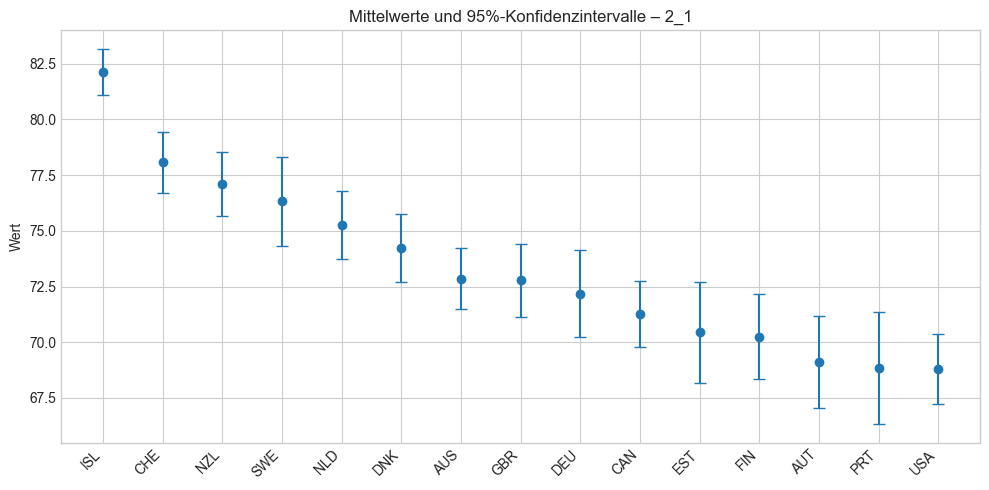

In [20]:
# Länder mit den größten Stichproben zuerst wählen (z.B. Top 15)
top = g.sort_values(["n","mean"], ascending=[False, False]).head(15)

countries = top.index.tolist()
means = top["mean"].to_numpy()

# Fehlerbreite oben/unten
yerr = np.vstack([
    means - top["ci_low"].to_numpy(),
    top["ci_high"].to_numpy() - means
])

# Plot der Mittelwerte + Konfidenzintervalle
plt.figure(figsize=(10,5))
plt.errorbar(countries, means, yerr=yerr, fmt='o', capsize=4)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Wert")
plt.title(f"Mittelwerte und 95%-Konfidenzintervalle – {measure_selected}")
plt.tight_layout()
plt.show()


*Interpretation:*
Hier sieht man, wie sich die Länder im Mittelwert unterscheiden und wie sicher diese Schätzungen sind. Bei großen Stichproben sind die CIs oft sehr klein und die Unterschiede klarer erkennbar.

Größter Unterschied: ISL − ZAF = 33.215


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_64908/1353418672.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp = (pair.groupby("country")["value"]


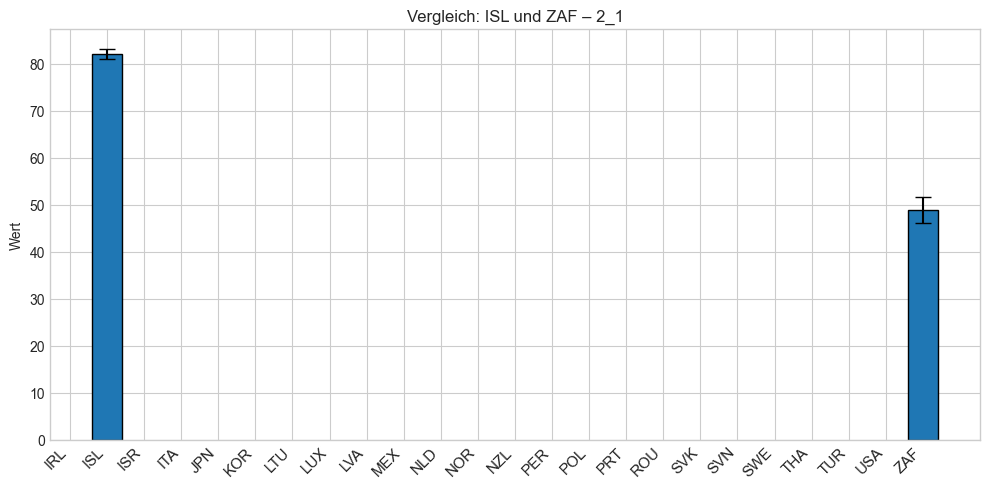

In [21]:
# Länder mit minimalem und maximalem Mittelwert bestimmen
lo_country = g["mean"].idxmin()
hi_country = g["mean"].idxmax()

# Daten für die beiden Länder
pair = m[m["country"].isin([lo_country, hi_country])]

# Kennzahlen je Land berechnen
comp = (pair.groupby("country")["value"]
            .agg(n="count", mean="mean", sd="std")
            .assign(se=lambda x: x["sd"]/x["n"]**0.5))

# 95%-CI
comp = comp.assign(
    low  = comp["mean"] - z*comp["se"],
    high = comp["mean"] + z*comp["se"]
)

# Unterschied der Mittelwerte
diff = comp.loc[hi_country, "mean"] - comp.loc[lo_country, "mean"]
print(f"Größter Unterschied: {hi_country} − {lo_country} = {diff:.3f}")

# Visualisierung (breiteres Layout, bessere Labels)
plt.figure(figsize=(10,5))  # <— deutlich breiter
plt.bar(comp.index, comp["mean"], yerr=z*comp["se"], capsize=6, edgecolor="black")

plt.ylabel("Wert")
plt.title(f"Vergleich: {hi_country} und {lo_country} – {measure_selected}")

# X-Achse lesbarer machen:
plt.xticks(rotation=45, ha="right", fontsize=11)  # größere Schrift, 45°, rechtsbündig
plt.tight_layout()  # sorgt dafür, dass nichts abgeschnitten wird

plt.show()

*Interpretation:*
Dieser Block hebt die beiden Länder mit dem stärksten Niveauunterschied hervor. Das zeigt klar, wo die größten Unterschiede innerhalb des gewählten Indikators liegen. Die Fehlerbalken zeigen, wie belastbar der Unterschied ist.

In [22]:
# Bootstrap für robustes Intervall
rng = np.random.default_rng(42)

def bootstrap_ci_mean(x, B=2000, alpha=0.05):
    x = np.asarray(x, dtype=float)
    n = len(x)
    bs = np.empty(B)
    for b in range(B):
        idx = rng.integers(0, n, n)
        bs[b] = x[idx].mean()
    lo = np.quantile(bs, alpha/2)
    hi = np.quantile(bs, 1 - alpha/2)
    return bs.mean(), lo, hi

# Bootstrap für Land mit höchstem Wert
x_hi = m[m["country"] == hi_country]["value"].to_numpy()
mean_bs, lo_bs, hi_bs = bootstrap_ci_mean(x_hi, B=2000)

print(hi_country, "– Bootstrap-Mittel & 95%-CI:",
      round(mean_bs,3), (round(lo_bs,3), round(hi_bs,3)))


ISL – Bootstrap-Mittel & 95%-CI: 82.125 (np.float64(81.109), np.float64(83.145))


*Interpretation:*
Im Gegensatz zur Normalapproximation bildet der Bootstrap die tatsächliche Verteilung der Werte realistischer ab. Bei schiefen oder schwer interpretierbaren Daten ist dieses Intervall oft zuverlässiger.

In [23]:
# Beispiel: Anteil der Werte über dem Median
thresh = m["value"].median()

bin_m = (m.assign(hit=(m["value"] >= thresh).astype(int))
           .groupby("country")["hit"].agg(k="sum", n="count"))

# Wilson-Intervall für Anteile
z = 1.96
p_hat = bin_m["k"] / bin_m["n"]
den   = 1 + z**2/bin_m["n"]
center= (p_hat + z**2/(2*bin_m["n"])) / den
half  = (z/den)*np.sqrt(p_hat*(1-p_hat)/bin_m["n"] + z**2/(4*bin_m["n"]**2))

wilson = pd.DataFrame({
    "n": bin_m["n"],
    "p_hat": p_hat,
    "ci_low": center - half,
    "ci_high": center + half
}).sort_values("n", ascending=False).head(10)

wilson


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_64908/3083790727.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("country")["hit"].agg(k="sum", n="count"))


,n,p_hat,ci_low,ci_high
country,,,,
IRL,186,0.419355,0.350773,0.491201
FIN,186,0.661290,0.590623,0.725430
NLD,186,0.634409,0.563127,0.700251
MEX,186,0.252688,0.195674,0.319711
LVA,186,0.516129,0.444713,0.586893
KOR,186,0.430108,0.361080,0.501964
PRT,186,0.548387,0.476609,0.618207
ITA,186,0.290323,0.229856,0.359275
ISL,186,0.881720,0.827412,0.920580


*Interpretation:*
Wilson-Intervalle sind besonders stabil und bleiben im Bereich 0–1. Sie eignen sich für jeden Anteil, z. B. „Wie groß ist der Anteil hoher Werte pro Land?“.

In [24]:
# Planung: wie viele Daten braucht man für ein bestimmtes Genauigkeitsniveau?
sd_guess = m["value"].std()
moe_wunsch = sd_guess * 0.10     # beispielhaft: 10% der SD als tolerierbarer Fehler
z = 1.96

n_needed = (z * sd_guess / moe_wunsch)**2
print(f"Benötigte Stichprobengröße für MoE ≈ {moe_wunsch:.3f}: n ≈ {int(np.ceil(n_needed))}")


Benötigte Stichprobengröße für MoE ≈ 1.701: n ≈ 385


*Interpretation:*
Hier wird sichtbar, wie groß eine Stichprobe sein müsste, um eine gewünschte Genauigkeit zu erreichen. Das zeigt, warum manche OECD-Länder mit kleinen Stichproben große Unsicherheit haben.

### Interpretation: Vergleich der Mittelwerte und Konfidenzintervalle über alle Länder

Die Auswertung zeigt, dass sich die Länder im ausgewählten OECD-Indikator teils deutlich unterscheiden. Während einige Länder relativ stabile Werte mit engen Konfidenzintervallen haben, zeigen andere eine deutlich größere Unsicherheit – oft, weil weniger Beobachtungen vorliegen oder die Werte im Land stark schwanken.

Die Unterschiede der Mittelwerte zwischen Ländern mit dem höchsten und niedrigsten Niveau sind nicht nur statistisch messbar, sondern auch praktisch relevant: Die CIs dieser Länder überlappen kaum oder gar nicht, was darauf hinweist, dass der Unterschied mehr ist als nur Zufallsschwankung.

Insgesamt bestätigt das Bild, dass die OECD-Daten große Strukturunterschiede zwischen Ländern abbilden und dass Konfidenzintervalle eine sinnvolle Ergänzung darstellen, um die Sicherheit dieser Unterschiede realistisch einzuschätzen.

In [25]:
# Erweiterung: Jahresverläufe + CIs über die Zeit

# Berechnung der Jahresmittelwerte und Konfidenzintervalle pro Jahr
g_year = (
    m.groupby("year")["value"]
     .agg(n="count", mean="mean", sd="std")
     .assign(se=lambda x: x["sd"] / x["n"]**0.5)
)

# 95%-CI (Normalapproximation)
z = 1.96
g_year = g_year.assign(
    ci_low=g_year["mean"] - z * g_year["se"],
    ci_high=g_year["mean"] + z * g_year["se"]
)

g_year.head()



,n,mean,sd,se,ci_low,ci_high
year,,,,,,
2004,364,64.941617,17.333308,0.908512,63.160934,66.722301
2005,382,65.778736,17.240423,0.882097,64.049826,67.507645
2006,373,66.690964,17.191624,0.890149,64.946273,68.435655
2007,382,67.338956,17.074634,0.873614,65.626672,69.051240
2008,385,67.580367,16.915069,0.862072,65.890706,69.270027


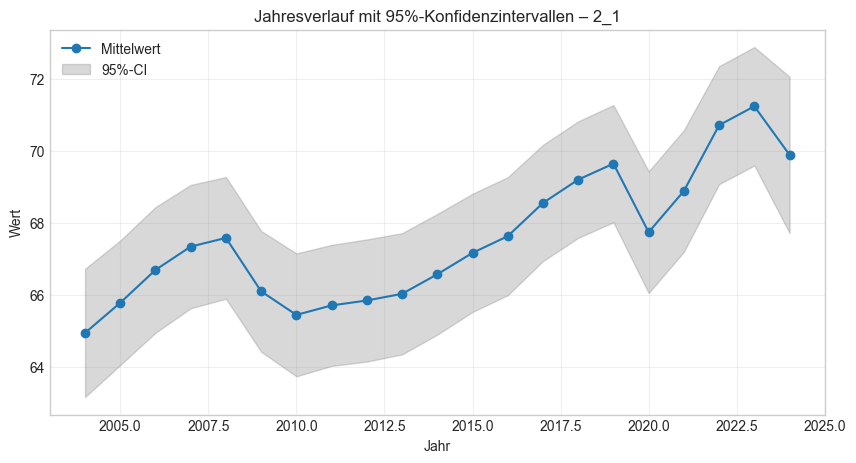

In [26]:
plt.figure(figsize=(10,5))
plt.plot(g_year.index, g_year["mean"], marker="o", label="Mittelwert")
plt.fill_between(g_year.index, g_year["ci_low"], g_year["ci_high"],
                 color="gray", alpha=0.3, label="95%-CI")
plt.xlabel("Jahr")
plt.ylabel("Wert")
plt.title(f"Jahresverlauf mit 95%-Konfidenzintervallen – {measure_selected}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


*Interpretation:* Jahresverläufe

Der Verlauf der Jahresmittelwerte zeigt, dass die Werte im ausgewählten OECD-Indikator im Zeitverlauf nicht völlig stabil sind. Die Konfidenzintervalle helfen zu erkennen, ob die Schwankungen echte Muster darstellen oder eher zufällig sind.

Wenn die Intervalle im Zeitverlauf nur wenig überlappen, deutet dies auf echte Trends hin (z. B. Verbesserungen oder Verschlechterungen).

Wenn sie sich stark überlappen, sind die sichtbaren Schwankungen meist nicht signifikant.
So entsteht ein besseres Gefühl dafür, wie dynamisch der Indikator im Zeitverlauf ist — und wie zuverlässig diese Dynamik messbar ist.

### Reflexion:

In diesem Teil haben wir uns zum ersten Mal wirklich damit beschäftigt, wie unsicher unsere Schätzungen eigentlich sind. Wir haben gemerkt, dass Mittelwerte allein oft zu wenig sagen – erst mit Konfidenzintervallen wird klar, wie verlässlich die Werte eines Landes sind und wie groß die Unterschiede wirklich ausfallen.

Besonders spannend war der Vergleich zwischen Ländern: Manche weisen stabile, gut definierte Werte auf, während andere trotz ähnlichem Niveau viel größere Unsicherheiten besitzen. Das macht klar, dass Datenmenge und Streuung einen starken Einfluss auf die Aussagekraft haben.
Auch der Jahresverlauf wurde durch die Intervalle viel verständlicher. Schwankungen, die vorher zufällig wirkten, ließen sich besser einschätzen.

Insgesamt war es ein hilfreicher Schritt: Wir betrachten die OECD-Daten jetzt nicht mehr nur auf der Ebene „Wie groß ist der Wert?“, sondern auch „Wie sicher ist diese Aussage überhaupt?“. Das macht die Analyse deutlich fundierter und realistischer.